<a href="https://colab.research.google.com/github/HRashidLiaquat/lessons-learned/blob/Transformer-based-crop-disease-detection-system/Agri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Workflow**


1.   Import Important Libraries
2.   Get Data Ready in Kaggle
3.   Preparing data
4.   Loading Training Images
5.   Data Loaders
6.   Transfermor Embedding layer
7.   Transfermor encoding
8.   Build a Traning Model (Transfer Learning)
9.   Model Training
10.  Model Testing (Training Loop)
11.  Model Evaluation
12.  Testing with New Data Point
13.  Save Model








**Import Important libraries**

In [128]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image
import zipfile
import random
import torchvision
import matplotlib.pyplot as plt



**Mount GDrive**

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Zip to unZip data**

In [87]:
zip_path = Path("/content/drive/MyDrive/Colab Notebooks/agriarchive.zip")
extract_path = Path("/content/data")

print("ZIP exists:", zip_path.exists())

extract_path.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

ZIP exists: True


**Get Ready dataset**

In [88]:
datset_path = Path('/content/data/PlantVillage')

if datset_path.exists():
  print("Dataset found!")
else:
  print("Dataset not found!")

Dataset found!


In [89]:
if datset_path.exists():
  datsetfolderlist = list(datset_path.iterdir())
  print("See all folder in my dataset main folder")
  for allfolder in datsetfolderlist:
      print(allfolder)

See all folder in my dataset main folder
/content/data/PlantVillage/val
/content/data/PlantVillage/train


**Check Total plant classes data**

In [90]:

traning_path = datset_path / '/content/data/PlantVillage/train'
print(traning_path)
# test_path = datset_path / '/content/data/PlantVillage/train/val'
train_classes = [item.name for item in traning_path.iterdir() if item.is_dir()]
train_classes.sort()
num_classes = len(train_classes)
print(f"Total plant classes: {num_classes}")
# print(test_path)

/content/data/PlantVillage/train
Total plant classes: 38


**Display Raw data**

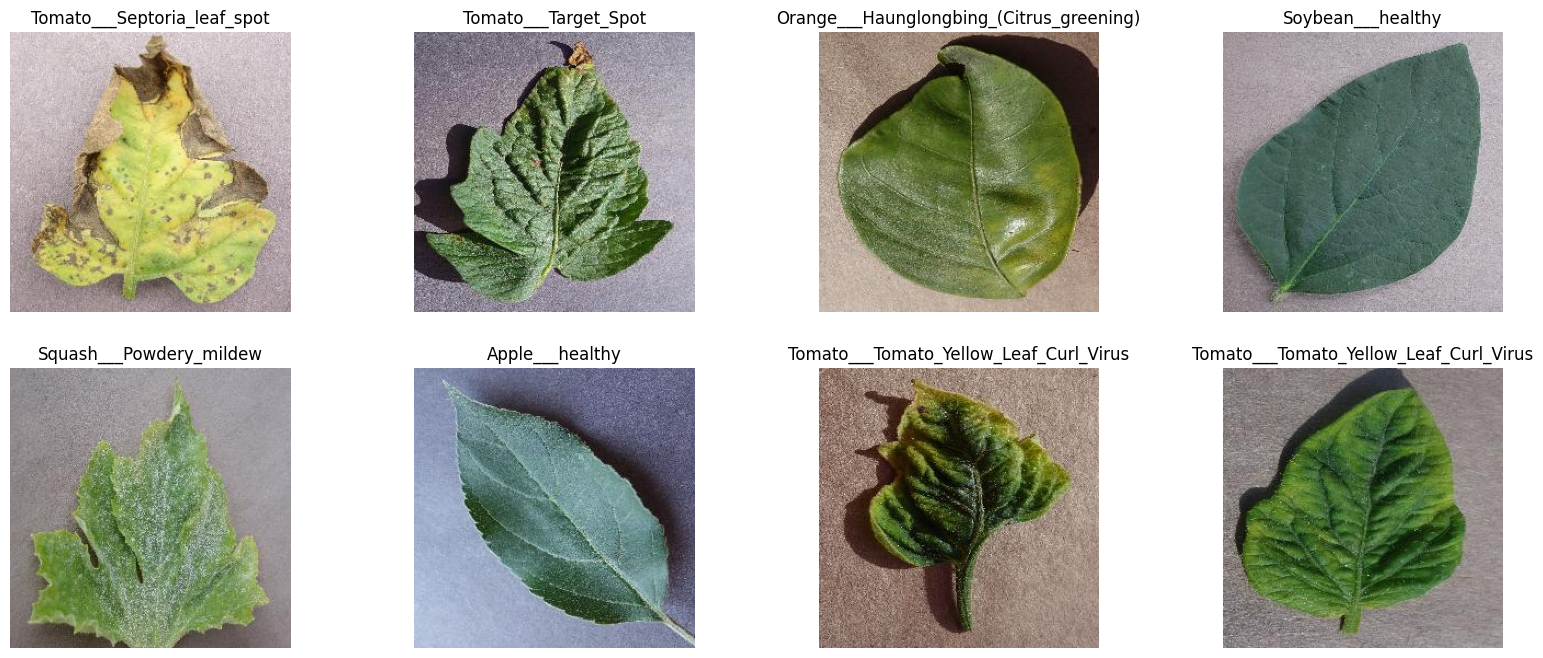

In [91]:
rawdataset = datasets.ImageFolder(traning_path, transform=transforms.ToTensor())

plt.figure(figsize=(20, 8))
for i in range(8):
    idx = random.randint(0, len(rawdataset)-1)
    img, label = rawdataset[idx]
    plt.subplot(2, 4, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(rawdataset.classes[label])
    plt.axis('off')

**Data Preprocessing (Normalization and augmentation)**

In [92]:
IMG_SIZE = 224
BATCH_SIZE = 16

**Data Augmentattion**

In [93]:
aug_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2,0.2,0.2)

])

In [94]:
aug_transforms

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
)

**WithOut augmentation**

In [95]:
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

**Data Preprocessing**



In [96]:
prepro_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [97]:
prepro_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

**Data Normaliztion**

In [98]:
normalization_transform = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

In [99]:
normalization_transform

Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [100]:
train_trasform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Show Data after Preprocessing**

In [101]:
processed_datase = datasets.ImageFolder(traning_path, transform=transforms.ToTensor())
def denorm(x):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return torch.clamp(x * std + mean, 0, 1)


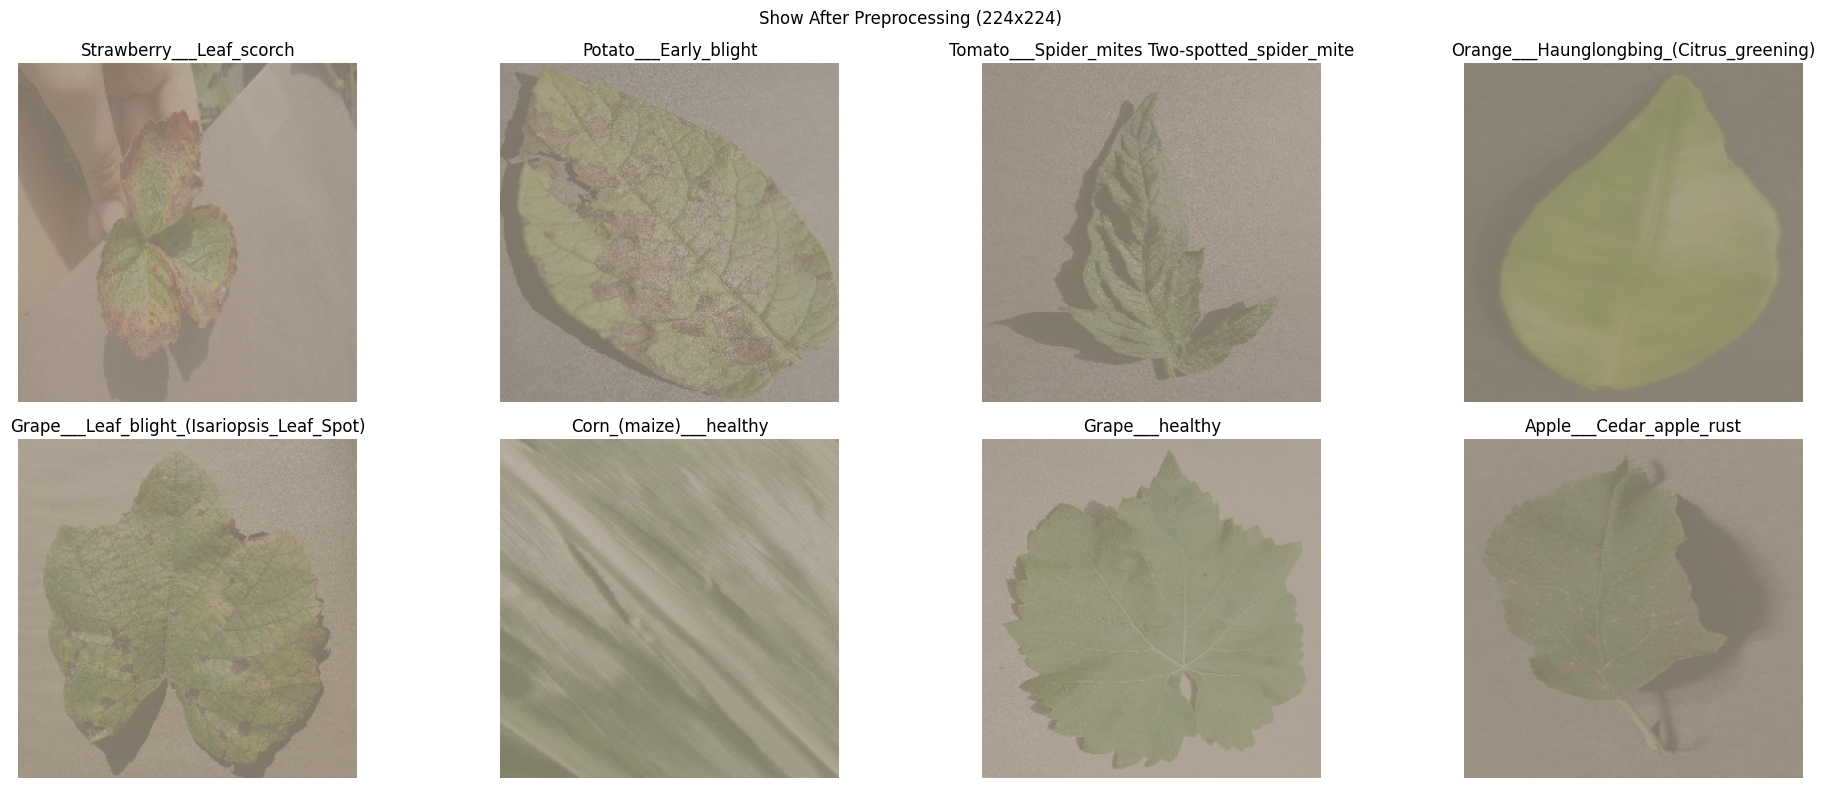

In [102]:
plt.figure(figsize=(20, 8))
for i in range(8):
    idx = random.randint(0, len(processed_datase)-1)
    img, label = processed_datase[idx]

    img = denorm(img)

    plt.subplot(2, 4, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(processed_datase.classes[label])
    plt.axis('off')

plt.suptitle('Show After Preprocessing (224x224)')
plt.tight_layout()
plt.show()

**Load Dataset**

In [103]:
dataset = datasets.ImageFolder(datset_path, transform=train_trasform)
print("Total images:", len(dataset))
print("Classes:", dataset.classes)

Total images: 54305
Classes: ['train', 'val']


In [104]:
train_dir = "/content/drive/MyDrive/PlantVillage/train"
val_path   = "/content/drive/MyDrive/PlantVillage/val"

In [105]:
train_dir ,val_path

('/content/drive/MyDrive/PlantVillage/train',
 '/content/drive/MyDrive/PlantVillage/val')

In [106]:
train_dir = '/content/data/PlantVillage/train'
val_path   = '/content/data/PlantVillage/val'

train_dataset = datasets.ImageFolder(train_dir, transform=train_trasform)
val_dataset   = datasets.ImageFolder(val_path, transform=test_transform)

print("Total train images:", len(train_dataset))
print("Train classes:", train_dataset.classes)
print("Total val images:", len(val_dataset))

Total train images: 43444
Train classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-

**Data Loaders**

In [107]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [108]:
train_loader, val_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f83c7701eb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f83c76b9820>)

**Visulize one batch data**

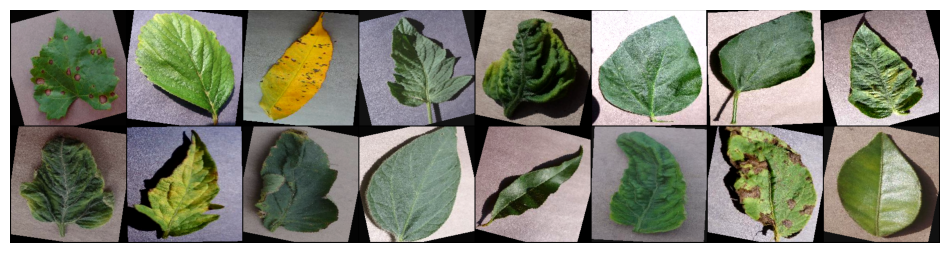

In [129]:
images, labels = next(iter(train_loader))
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

unnormalized = images * std + mean
grid = torchvision.utils.make_grid(unnormalized, nrow=8)

plt.figure(figsize=(12, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()


**Embedding layer**

In [109]:
class SplitPatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=256):
        super().__init__()
        self.projection = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

In [110]:
SplitPatchEmbedding()

SplitPatchEmbedding(
  (projection): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
)

**`Transformer Encoder`**

In [115]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=256,
                 num_heads=8, mlp_ratio=4):
        super().__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * mlp_ratio),
            nn.GELU(),
            nn.Linear(embed_dim * mlp_ratio, embed_dim)
        )

    def forward(self, x):
        x_norm = self.norm1(x)
        attn_output, _ = self.attention(x_norm, x_norm, x_norm)
        x = x + attn_output

        x_norm = self.norm2(x)
        x = x + self.mlp(x_norm)

        return x


In [116]:
TransformerEncoder

__main__.TransformerEncoder

**Model Bulding**

In [123]:
class Transformer(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        embed_dim=256,
        num_heads=8,
        num_layers=6,
        num_classes=10
    ):
        super().__init__()

        self.patch_embed = SplitPatchEmbedding(img_size, patch_size, 3, embed_dim)

        num_patches = (img_size // patch_size) ** 2

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        self.encoder_layers = nn.ModuleList([
            TransformerEncoder(embed_dim, num_heads)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embedding

        x = x.transpose(0, 1)
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.transpose(0, 1)

        x = self.norm(x[:, 0])
        return self.classifier(x)


**Object for transfer model**

In [125]:
model = Transformer(
    img_size=224,
    patch_size=16,
    embed_dim=256,
    num_heads=8,
    num_layers=6,
    num_classes=38
)

In [126]:
model

Transformer(
  (patch_embed): SplitPatchEmbedding(
    (projection): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x TransformerEncoder(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_features=256, out_features=38, bias=True)
)

**Move Device cpu to gpu**